In [1]:
from glob import glob
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import cv2
from natsort import natsorted
import numpy as np
import pandas as pd
import re
from sklearn.metrics.pairwise import manhattan_distances
# from utils import rmse
import scipy


In [2]:
# covarianzas = []
# for i,row in datos.iterrows():
#     m_cov = np.cov(np.array(row.filter(regex="\w+_casillas").to_list()), rowvar=False)
#     covarianzas.append(m_cov)


In [3]:
words = pd.read_excel("Words_Hues&Clues_Eng.xlsx")
words = words.rename({"palabra": "word"}, axis=1)

palabras = pd.read_excel("Palabras_Hues&Clues.xlsx")

words_palabras = pd.concat([words, palabras], axis=1)
words_palabras = words_palabras[["palabra", "word"]]
words_palabras.head()

,palabra,word
0,SALMÓN,SALMON
1,BALLENA,WHALE
2,PARDO,GRIZZLY
3,FLAMENCO,FLAMINGO
4,ZORRO,FOX


In [4]:
humanos = pd.read_csv("HC.csv")
humanos.head()

,userId,timestamp,clueCategory,clueId,word,coordinate,language,gender,ageRange
0,4ae551a8-0d2b-4b34-ab64-8e6721cbe470,2025-07-15T17:14:02.825Z,ANIMAL,1,SALMÓN,E11,spanish,female,20-29
1,4ae551a8-0d2b-4b34-ab64-8e6721cbe470,2025-07-15T17:14:41.330Z,ANIMAL,2,BALLENA,K26,spanish,female,20-29
2,4ae551a8-0d2b-4b34-ab64-8e6721cbe470,2025-07-15T17:14:48.713Z,ANIMAL,3,PARDO,C2,spanish,female,20-29
3,4ae551a8-0d2b-4b34-ab64-8e6721cbe470,2025-07-15T17:15:21.721Z,ANIMAL,4,FLAMENCO,C15,spanish,female,20-29
4,4ae551a8-0d2b-4b34-ab64-8e6721cbe470,2025-07-15T17:15:31.790Z,ANIMAL,5,ZORRO,C7,spanish,female,20-29


In [5]:
def translate(palabra):
    if palabra in words_palabras.palabra.to_list():
        palabra = words_palabras[words_palabras.palabra == palabra].word.item()
    return palabra

In [6]:
humanos["word"] = humanos["word"].apply(translate)
humanos = humanos.sort_values("word")
humanos.head()

,userId,timestamp,clueCategory,clueId,word,coordinate,language,gender,ageRange
214,aff9cab7-c577-4460-a48d-b950faa9ea4f,2025-08-06T09:27:28.891Z,PIEDRA,38,AMBER,D7,spanish,female,20-29
2695,c5b625eb-0902-41b2-876a-23430f39370c,2026-01-15T15:47:36.913Z,PIEDRA,38,AMBER,A10,spanish,male,20-29
2757,c8bd2c5a-6f6f-4f3e-b8bb-b33363bff060,2026-01-16T11:09:39.570Z,PIEDRA,38,AMBER,G30,spanish,female,10-19
960,16e350bc-f5c7-4126-8448-e3ddf466fa68,2025-12-03T11:25:50.904Z,PIEDRA,38,AMBER,F2,spanish,male,20-29
159,ea29d7a2-4c36-4cb1-b13d-6f3a0dd8005f,2025-08-06T09:13:42.220Z,PIEDRA,38,AMBER,E6,spanish,male,20-29


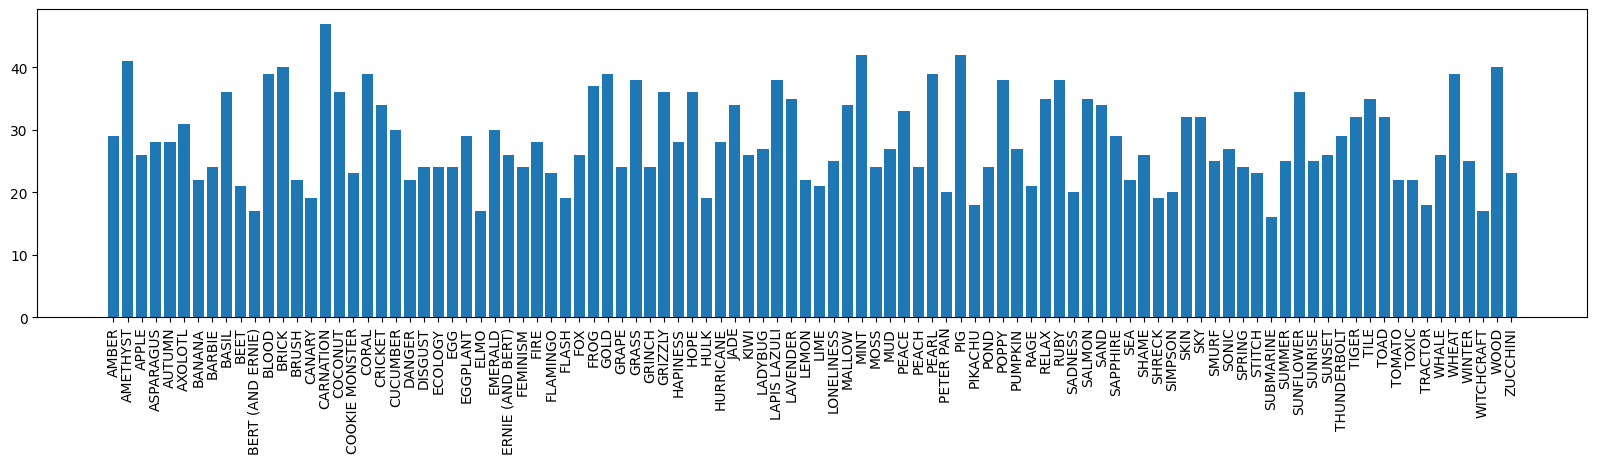

In [7]:
from collections import Counter
ctr = Counter(humanos.word)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.bar(ctr.keys(), ctr.values())
plt.xticks(rotation=90)
plt.show()

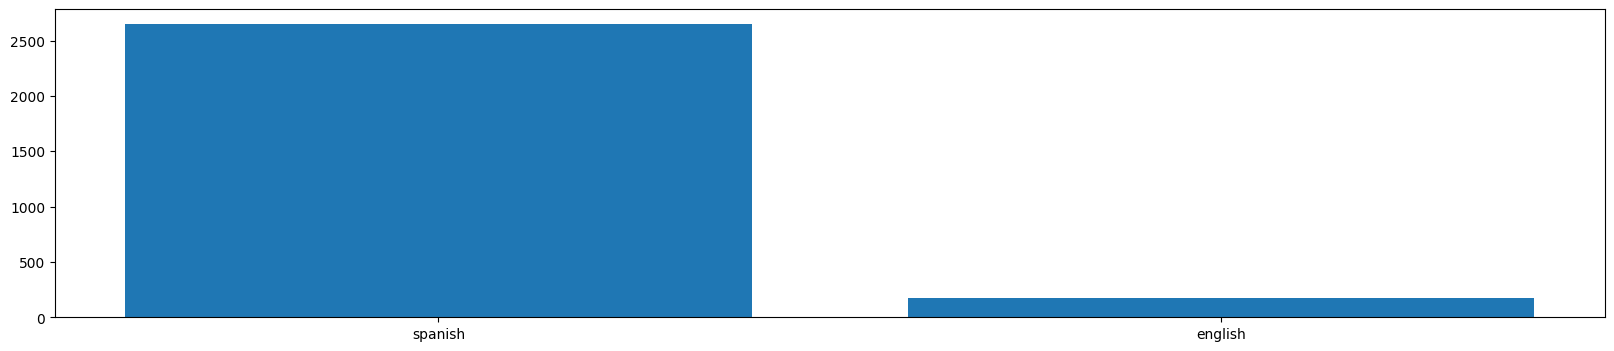

In [8]:
from collections import Counter
ctr = Counter(humanos.language)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.bar(ctr.keys(), ctr.values())
plt.show()

In [9]:
from collections import defaultdict

respuesta = []
contador = defaultdict(lambda: 0)
for i, row in humanos.iterrows():
    contador[row.word] += 1
    respuesta.append(contador[row.word])
    # break

In [10]:
humanos["respuesta"] = respuesta
humanos.head()

,userId,timestamp,clueCategory,clueId,word,coordinate,language,gender,ageRange,respuesta
214,aff9cab7-c577-4460-a48d-b950faa9ea4f,2025-08-06T09:27:28.891Z,PIEDRA,38,AMBER,D7,spanish,female,20-29,1
2695,c5b625eb-0902-41b2-876a-23430f39370c,2026-01-15T15:47:36.913Z,PIEDRA,38,AMBER,A10,spanish,male,20-29,2
2757,c8bd2c5a-6f6f-4f3e-b8bb-b33363bff060,2026-01-16T11:09:39.570Z,PIEDRA,38,AMBER,G30,spanish,female,10-19,3
960,16e350bc-f5c7-4126-8448-e3ddf466fa68,2025-12-03T11:25:50.904Z,PIEDRA,38,AMBER,F2,spanish,male,20-29,4
159,ea29d7a2-4c36-4cb1-b13d-6f3a0dd8005f,2025-08-06T09:13:42.220Z,PIEDRA,38,AMBER,E6,spanish,male,20-29,5


In [11]:
humanos = humanos.pivot(index="word", columns=["respuesta"], values=["coordinate"])
humanos.columns = range(1,humanos.shape[1]+1)
humanos = humanos.reset_index()
humanos.head()

,word,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,AMBER,D7,A10,G30,F2,E6,F2,D5,I3,C8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMETHYST,E23,I26,G26,M10,E28,K26,L28,F26,C22,...,D24,E28,B24,E27,NaN,NaN,NaN,NaN,NaN,NaN
2,APPLE,J5,N10,B12,N11,B8,A13,B11,M8,K10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ASPARAGUS,P10,P12,N11,O11,N15,K16,P9,P10,L12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUTUMN,C2,D4,E6,D6,A2,D8,C5,D6,D5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
rgb = pd.read_csv("HC_RGB.csv")
rgb.head()

,coordenada_x,coordenada_y,R,G,B
0,A,1,82,48,27
1,A,2,90,47,30
2,A,3,99,43,32
3,A,4,109,44,35
4,A,5,124,45,38


In [13]:
from perceptualtests.color_matrices import Mng2xyz

In [14]:
def get_xyz(row):
    rgb = row[["R", "G", "B"]].to_numpy()
    rgb = rgb[None,:]
    ng = rgb**(2)
    xyz = ng @ Mng2xyz.T
    xyz = xyz/xyz.sum()
    xyz = xyz[0]
    return {"x": xyz[0], "y": xyz[1], "z": xyz[2]}

In [15]:
valores_tri = pd.concat([rgb, rgb.apply(get_xyz, axis=1, result_type="expand")], axis=1)
valores_tri["C"] = valores_tri.apply(lambda row: f"{row.coordenada_x}{row.coordenada_y}", axis=1)
valores_tri.head()

,coordenada_x,coordenada_y,R,G,B,x,y,z,C
0,A,1,82,48,27,0.463707,0.404878,0.131415,A1
1,A,2,90,47,30,0.474592,0.387820,0.137588,A2
2,A,3,99,43,32,0.493604,0.368145,0.138251,A3
3,A,4,109,44,35,0.499911,0.361061,0.139028,A4
4,A,5,124,45,38,0.511546,0.354994,0.133461,A5


In [16]:
def casilla2cord(x): 
    if x is not np.nan:
        return valores_tri[valores_tri.C == x][["x", "y"]].to_numpy()[0]
    else: return x

In [17]:
# humanos = humanos["PAULA", "MARÍA", "NURIA", "JORGE", "PABLO", "JOSEP"]
# palabras_id = [0, 2, 12, 13, 14, 16]
humanos_tri = humanos.iloc[:,1:].applymap(casilla2cord)
humanos_tri

,1,2,3,4,5,6,7,8,9,10,...,38,39,40,41,42,43,44,45,46,47
0,"[0.506649539473491, 0.3979759917131791]","[0.5479273716965943, 0.36083230269713507]","[0.24843453778593091, 0.16485696169195507]","[0.46269596234429355, 0.4641187713348691]","[0.49232204387548023, 0.4149120812546612]","[0.46269596234429355, 0.4641187713348691]","[0.496591673725462, 0.41215315398654206]","[0.43004024382329065, 0.4793164914414959]","[0.5367277246921449, 0.3729542515060594]","[0.42818820647254974, 0.42958170175369764]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[0.32253110990694883, 0.2365439916691776]","[0.2652417829941415, 0.2311244365101121]","[0.2740215200070822, 0.21245697637658725]","[0.34647698839882857, 0.4733518117150162]","[0.27855537389925117, 0.17582288518637668]","[0.262330670173787, 0.2532639868875824]","[0.25573365328925685, 0.23865141152019628]","[0.28520758048987765, 0.2057866772052759]","[0.35263939977226966, 0.24267976825184176]","[0.26113675332002617, 0.3046939842113812]",...,"[0.32651777195589243, 0.2309917060044943]","[0.27855537389925117, 0.17582288518637668]","[0.3498733336000467, 0.2315586547474137]","[0.2879178596031261, 0.19654996588759938]",NaN,NaN,NaN,NaN,NaN,NaN
2,"[0.4089720723894585, 0.4748310611308022]","[0.3352234981824084, 0.49647564915388115]","[0.5280383957491794, 0.3491698557332777]","[0.32886715304242464, 0.4929139667012789]","[0.5412520184734637, 0.36050104527269106]","[0.5469530551598266, 0.3528737003364192]","[0.5317499349869477, 0.3572333181615554]","[0.3624934260446248, 0.4842303545245138]","[0.36421523332996597, 0.4378784911886001]","[0.3624934260446248, 0.4842303545245138]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[0.30601961361894225, 0.4614788232923974]","[0.3036991221869269, 0.4654989056228595]","[0.32886715304242464, 0.4929139667012789]","[0.31440171129984557, 0.47699137255762186]","[0.31158672181230457, 0.4492492188398309]","[0.3190311899923146, 0.3655228415287269]","[0.3085458702504204, 0.4682002712403613]","[0.30601961361894225, 0.4614788232923974]","[0.33870345937060314, 0.4315654139602077]","[0.31440171129984557, 0.47699137255762186]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[0.4718709156248054, 0.412564806469639]","[0.48678773391283475, 0.4257732725910548]","[0.49232204387548023, 0.4149120812546612]","[0.5069932049989496, 0.40377720197106926]","[0.47459208141445075, 0.38782014453777724]","[0.5075129991804482, 0.3960768079168282]","[0.5080800374307154, 0.3875761361927467]","[0.5069932049989496, 0.40377720197106926]","[0.496591673725462, 0.41215315398654206]","[0.48419248652494806, 0.43909152444234784]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[0.4094348018066015, 0.45383349247962995]","[0.4210464822240339, 0.4884126092390944]","[0.4117009550404072, 0.47994717870947784]","[0.46075854658642834, 0.4552491985877971]","[0.4502537308113327, 0.4367111358141228]","[0.4355745988839579, 0.46041025544958936]","[0.43614971502809935, 0.4880446384020075]","[0.412082887324232, 0.4944852983022246]","[0.47474759673250316, 0.44998685566407604]","[0.382984019478299, 0.40669957871407914]",...,"[0.45757528053185953, 0.4409470915300157]","[0.4210464822240339, 0.4884126092390944]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,"[0.2601716129542066, 0.22811547119239958]","[0.27884548703330775, 0.30833620329125333]","[0.26194010504725557, 0.2880664658369398]","[0.2518079310402987, 0.20911568808431558]","[0.26194010504725557, 0.2880664658369398]","[0.27884548703330775, 0.30833620329125333]","[0.25125996647933835, 0.245612104219081]","[0.25996896002464936, 0.21658968705605844]","[0.2902048463252024, 0.31325681895002877]","[0.3213551433430566, 0.3337937566203492]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,"[0.3410810979864618, 0.24340123958445847]","[0.32464748821816636, 0.2162738330832362]","[0.29554329796206896, 0.1991389294590491]","[0.3328563331431756, 0.25380452108150353]","[0.3701531839756768, 0.304801766396018]","[0.301

In [18]:
means, covs = [], []
for i, r in humanos_tri.iterrows():
    r = np.array([_ for _ in r[~pd.isna(r)]])
    mean = r.mean(axis=0)
    cov = np.cov(r, rowvar=False)
    means.append(mean)
    covs.append(cov)
    # break
mean, cov

(array([0.3368214 , 0.46076901]),
 array([[ 0.0037024 , -0.00142326],
        [-0.00142326,  0.00081277]]))

In [19]:
def confidence_ellipse(mean, cov, ax, facecolor='none', n_stds=1, **kwargs):
    eigval, eigvec = np.linalg.eig(cov)
    theta = np.arccos(eigvec[0,0])*180/np.pi
    width = eigval[0]**(1/2)*n_stds
    height = eigval[1]**(1/2)*n_stds
    ellipse = Ellipse(mean, width=width, height=height, angle=theta,
                      facecolor=facecolor, **kwargs)

    return ax.add_patch(ellipse)

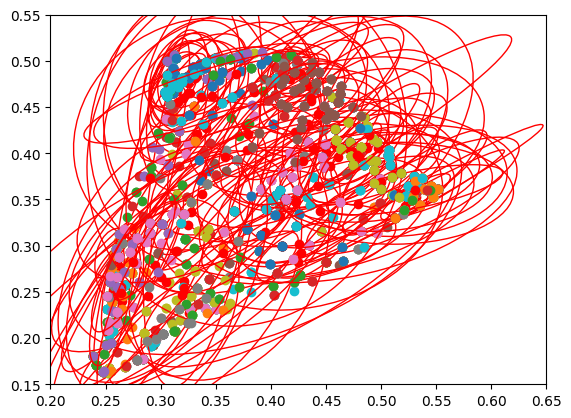

In [20]:
fig, ax = plt.subplots()
# plt.scatter(r[:,0], r[:,1])
for mean, cov, (i, r) in zip(means, covs, humanos_tri.iterrows()):
    r = np.array([_ for _ in r[~pd.isna(r)]])
    plt.scatter(r[:,0], r[:,1])
    plt.scatter(mean[0], mean[1], color="r")
    confidence_ellipse(mean, cov, ax=ax, edgecolor="red", n_stds=3.5)
ax.set_xlim([0.2, 0.65])
ax.set_ylim([0.15, 0.55])
# ax.set_box_aspect(1)
plt.show()

In [21]:
means = np.stack(means)
# np.save("Results/Humans/means.npy", means)
means.shape

(100, 2)

In [22]:
covs = np.stack(covs)
# np.save("Results/Humans/covs.npy", covs)
covs.shape

(100, 2, 2)

In [23]:
from glob import glob
import re

In [38]:
model_path = list(glob("Results/*/results.csv"))[1]
model = pd.read_csv(model_path)
model = model.sort_values("word")
model["C"] = model.apply(lambda row: f"{row.coordenada_x}{row.coordenada_y}", axis=1)
## Nos quedamos solo con la de mayor similitud
model = model.iloc[np.arange(4,len(model), 5)]
model["distance"] = model.distance.abs()
model.head()

,word,coordenada_x,coordenada_y,R,G,B,distance,C
187,AMBER,E,5,217,125,46,0.233102,E5
154,AMETHYST,B,21,163,68,122,0.083182,B21
122,APPLE,I,13,207,190,146,0.238494,I13
110,ASPARAGUS,I,18,191,193,194,0.186106,I18
384,AUTUMN,D,7,211,99,50,0.185727,D7


In [39]:
model.shape

(100, 8)

In [ ]:
model_prob = model.distance.to_numpy().reshape(100,5)
model_prob.shape

(100, 1)

In [52]:
respuesta = []
contador = defaultdict(lambda: 0)
for i, row in model.iterrows():
    contador[row.word] += 1
    respuesta.append(contador[row.word])
    # break

In [53]:
model["respuesta"] = respuesta

In [54]:
model = model.pivot(index="word", columns=["respuesta"], values=["C"])
model.columns = range(1,6)
model = model.reset_index()
model.head()

,word,1,2,3,4,5
0,AMBER,F6,E2,E4,E3,E5
1,AMETHYST,A22,A23,A21,B22,B21
2,APPLE,E17,C19,D18,F17,I13
3,ASPARAGUS,L10,L11,I17,L12,I18
4,AUTUMN,D4,D3,E5,D8,D7


In [55]:
# humanos = humanos["PAULA", "MARÍA", "NURIA", "JORGE", "PABLO", "JOSEP"]
# palabras_id = [0, 2, 12, 13, 14, 16]
model_tri = model.iloc[:,1:].applymap(casilla2cord)
model_tri

,1,2,3,4,5
0,"[0.44749601882594686, 0.42555106895490313]","[0.47474759673250316, 0.44998685566407604]","[0.48419248652494806, 0.43909152444234784]","[0.4815276005176902, 0.4403580968108096]","[0.48700171263903413, 0.4295506179591937]"
1,"[0.3872355520502793, 0.24173837773681756]","[0.37960160259563935, 0.2403929546745746]","[0.4023775618814951, 0.24611673448821708]","[0.3704719814949941, 0.24139404313118684]","[0.38161339901291474, 0.24979422763392525]"
2,"[0.37166293431712544, 0.28762677983010043]","[0.3888466005293011, 0.2646674766593086]","[0.381497770348582, 0.27155041786519596]","[0.35618261317888456, 0.29748726295201444]","[0.3594290963568451, 0.380960716108682]"
3,"[0.3555992459343021, 0.4539586437584161]","[0.34667195103633497, 0.4419451687131807]","[0.3213551433430566, 0.3337937566203492]","[0.33870345937060314, 0.4315654139602077]","[0.31827623620223977, 0.3244439342470169]"
4,"[0.48678773391283475, 0.4257732725910548]","[0.4809176658387402, 0.4272613373617926]","[0.48700171263903413, 0.4295506179591937]","[0.5075129991804482, 0.3960768079168282]","[0.506649539473491, 0.3979759917131791]"
...,...,...,...,...,...
95,"[0.3352234981824084, 0.49647564915388115]","[0.3306133227967522, 0.48567934895242426]","[0.3328268902146595, 0.48374121239390705]","[0.32717063639099264, 0.48486148216079095]","[0.3360985134656184, 0.48958903453292385]"
96,"[0.31459743418676694, 0.2945605937828149]","[0.32195717360200216, 0.3067963798456726]","[0.32010335671085155, 0.3008523805330417]","[0.3064256572174038, 0.3133858936040437]","[0.31827623620223977, 0.3244439342470169]"
97,"[0.4023775618814951, 0.24611673448821708]","[0.3872355520502793, 0.24173837773681756]","[0.37960160259563935, 0.2403929546745746]","[0.38161339901291474, 0.24979422763392525]","[0.3704719814949941, 0.24139404313118684]"
98,"[0.32195717360200216, 0.3067963798456726]","[0.31827623620223977, 0.3244439342470169]","[0.32010335671085155, 0.3008523805330417]","[0.31459743418676694, 0.2945605937828149]","[0.3340267206896554, 0.31601632724313855]"


In [56]:
means_m, covs_m = [], []
for (i, r), p in zip(model_tri.iterrows(), model_prob):
    r = np.array([_ for _ in r])
    mean = np.average(r, axis=0, weights=p)
    cov = np.cov(r, rowvar=False, aweights=p)
    means_m.append(mean)
    covs_m.append(cov)
    # break

ValueError: aweights cannot be negative

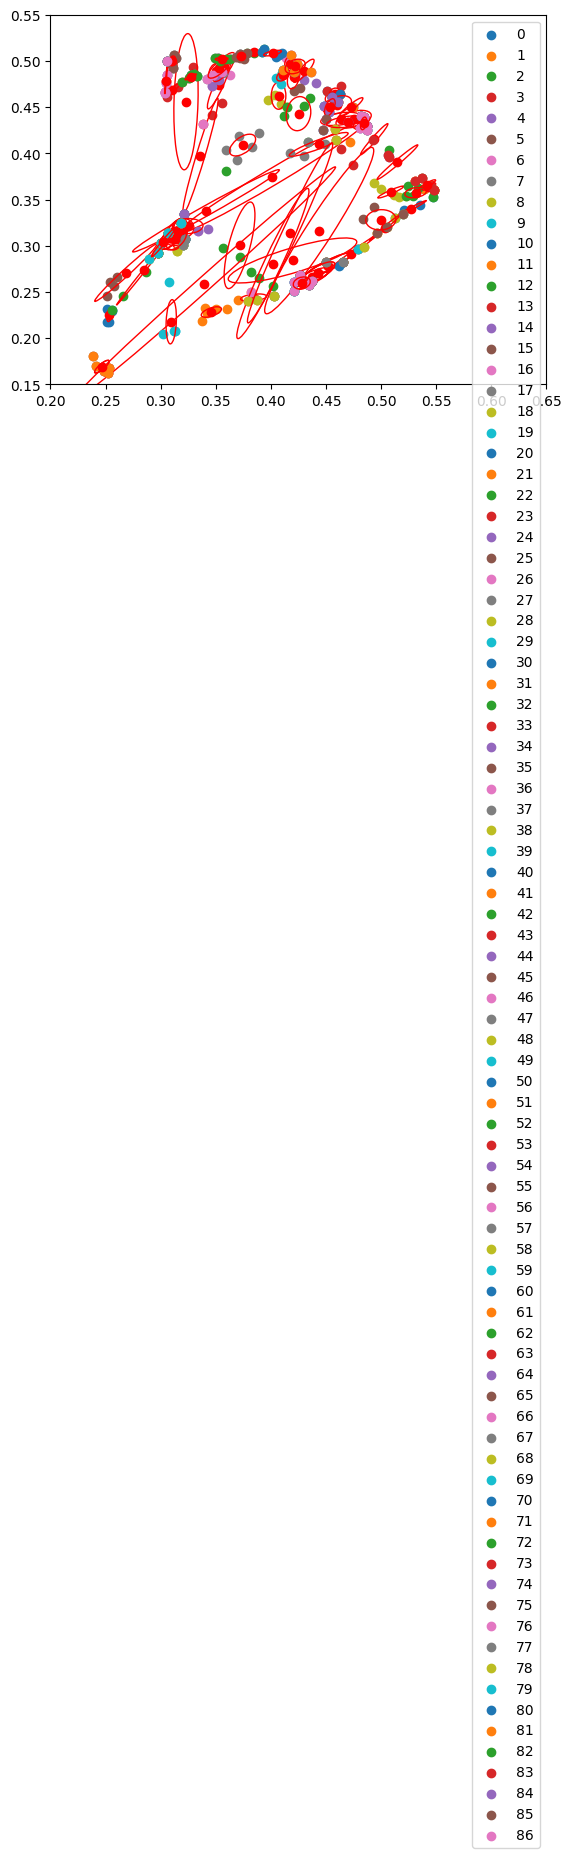

In [57]:
fig, ax = plt.subplots()
# plt.scatter(r[:,0], r[:,1])
for i, (mean, cov, (i, r)) in enumerate(zip(means_m, covs_m, model_tri.iterrows())):
    r = np.array([_ for _ in r])
    plt.scatter(r[:,0], r[:,1], label=i)
    plt.scatter(mean[0], mean[1], color="r")
    confidence_ellipse(mean, cov, ax=ax, edgecolor="red", n_stds=2)
ax.set_xlim([0.2, 0.65])
ax.set_ylim([0.15, 0.55])
# ax.set_box_aspect(1)
plt.legend()
plt.show()

In [58]:
# tests = []
# for (i, m), (j, h) in zip(model_tri.iterrows(), humanos_tri.iterrows()):
#     h = np.array([_ for _ in h])
#     m = np.array([_ for _ in m])
#     test = scipy.stats.ttest_ind(h, m, equal_var=False)
#     tests.append(test)

#     # mean = np.average(r, axis=0, weights=p)
#     # cov = np.cov(r, rowvar=False, aweights=p)
#     # means_m.append(mean)
#     # covs_m.append(cov)
#     # break

In [59]:
import numpy as np
from sklearn import datasets
from scipy.stats import f
def TwoSampleT2Test(X, Y, weights_Y=None):
    nx, p = X.shape
    ny, _ = Y.shape
    if weights_Y is None:
        weights_Y = np.ones(shape=(ny))

    delta = np.mean(X, axis=0) - np.average(Y, axis=0, weights=weights_Y)
    Sx = np.cov(X, rowvar=False)
    Sy = np.cov(Y, rowvar=False, aweights=weights_Y)

    S_pooled = ((nx-1)*Sx + (ny-1)*Sy)/(nx+ny-2)
    t_squared = (nx*ny)/(nx+ny) * np.matmul(np.matmul(delta.transpose(), np.linalg.inv(S_pooled)), delta)
    statistic = t_squared * (nx+ny-p-1)/(p*(nx+ny-2))
    F = f(p, nx+ny-p-1)
    p_value = 1 - F.cdf(statistic)
    print(f"Test statistic: {statistic}\nDegrees of freedom: {p} and {nx+ny-p-1}\np-value: {p_value}")
    return statistic, p_value

iris = datasets.load_iris()
versicolor = iris.data[iris.target==1, :2]
virginica = iris.data[iris.target==2, :2]
TwoSampleT2Test(versicolor, virginica)

Test statistic: 15.82660099191812
Degrees of freedom: 2 and 97
p-value: 1.1259783253558808e-06


(15.82660099191812, 1.1259783253558808e-06)

In [62]:
tests = []
pvs = []
for (i, m), p, (j, h) in zip(model_tri.iterrows(), model_prob, humanos_tri.iterrows()):
    h = h[~pd.isna(h)]
    h = np.array([_ for _ in h])
    m = np.array([_ for _ in m])
    test, pv = TwoSampleT2Test(h, m, weights_Y=abs(p))
    tests.append(test)
    pvs.append(pv)

Test statistic: 0.24540781395528413
Degrees of freedom: 2 and 31
p-value: 0.7838909695928483
Test statistic: 3.708853992184977
Degrees of freedom: 2 and 43
p-value: 0.03266142858468202
Test statistic: 107.43211589833052
Degrees of freedom: 2 and 28
p-value: 7.327471962526033e-14
Test statistic: 7.194890177832299
Degrees of freedom: 2 and 30
p-value: 0.002802682354318242
Test statistic: 2.147278789669501
Degrees of freedom: 2 and 30
p-value: 0.13441283842527563
Test statistic: 25.5257072964906
Degrees of freedom: 2 and 33
p-value: 1.9975012588435703e-07
Test statistic: 1.6413587914533765
Degrees of freedom: 2 and 24
p-value: 0.21472537569174177
Test statistic: 4.513098287919359
Degrees of freedom: 2 and 26
p-value: 0.02077517899784187
Test statistic: 34.9464684452322
Degrees of freedom: 2 and 38
p-value: 2.4491819683447602e-09
Test statistic: 0.8820863911887752
Degrees of freedom: 2 and 23
p-value: 0.4274606297816269
Test statistic: 12.015066097686256
Degrees of freedom: 2 and 19
p-valu

In [63]:
tests[0]

0.24540781395528413

In [64]:
d = {'Words': humanos.word.unique(), "Stat" : tests, "p-value" : pvs}

In [65]:
a = pd.DataFrame(d)

In [66]:
a

,Words,Stat,p-value
0,AMBER,0.245408,7.838910e-01
1,AMETHYST,3.708854,3.266143e-02
2,APPLE,107.432116,7.327472e-14
3,ASPARAGUS,7.194890,2.802682e-03
4,AUTUMN,2.147279,1.344128e-01
...,...,...,...
95,WHEAT,51.462844,6.610490e-12
96,WINTER,13.937794,6.946911e-05
97,WITCHCRAFT,8.161704,2.764169e-03
98,WOOD,1368.015640,1.110223e-16


In [67]:
a

,Words,Stat,p-value
0,AMBER,0.245408,7.838910e-01
1,AMETHYST,3.708854,3.266143e-02
2,APPLE,107.432116,7.327472e-14
3,ASPARAGUS,7.194890,2.802682e-03
4,AUTUMN,2.147279,1.344128e-01
...,...,...,...
95,WHEAT,51.462844,6.610490e-12
96,WINTER,13.937794,6.946911e-05
97,WITCHCRAFT,8.161704,2.764169e-03
98,WOOD,1368.015640,1.110223e-16


In [68]:
p_lim = 0.003

In [69]:
print(len(a[a["p-value"]<p_lim]))
a[a["p-value"]<p_lim]

61


,Words,Stat,p-value
2,APPLE,107.432116,7.327472e-14
3,ASPARAGUS,7.194890,2.802682e-03
5,AXOLOTL,25.525707,1.997501e-07
8,BASIL,34.946468,2.449182e-09
10,BERT (AND ERNIE),12.015066,4.239540e-04
...,...,...,...
95,WHEAT,51.462844,6.610490e-12
96,WINTER,13.937794,6.946911e-05
97,WITCHCRAFT,8.161704,2.764169e-03
98,WOOD,1368.015640,1.110223e-16


In [70]:
a[a["p-value"]>p_lim]

,Words,Stat,p-value
0,AMBER,0.245408,0.783891
1,AMETHYST,3.708854,0.032661
4,AUTUMN,2.147279,0.134413
6,BANANA,1.641359,0.214725
7,BARBIE,4.513098,0.020775
9,BEET,0.882086,0.427461
12,BRICK,2.655387,0.082049
15,CARNATION,2.683972,0.078325
18,CORAL,1.618650,0.210573
22,DISGUST,3.683619,0.039038
